<a href="https://colab.research.google.com/github/pranavirohit/cancer-drug-discovery/blob/main/prediction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
from numpy import vstack

## PyTorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
from torch.utils.data import DataLoader
from torch.nn import ReLU
from torch.nn import Sigmoid

In [ ]:
from torch.utils.data import TensorDataset

## Sklearn

In [ ]:
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers as L

# Preparing Input Data (1)

In [ ]:
drug_rp_repurposing_2 = pd.read_csv('/content/drive/MyDrive/Data/drug_rp_repurposing_2.csv')

In [ ]:
# Printing original number of drugs.
print(drug_rp_repurposing_2.shape)

# Eliminating all drugs without a SMILES code.
drug_rp_repurposing_2.Smiles = drug_rp_repurposing_2.Smiles.replace('nan', np.nan)
drug_rp_repurposing_2 = drug_rp_repurposing_2[drug_rp_repurposing_2['Smiles'].notna()]

# Printing updated number of drugs.
print(drug_rp_repurposing_2.shape)

(2427, 3)
(2418, 3)


### SMILES Encoding & Flattening

In [ ]:
# Defining SMILES characters (assigning a number value to each character).
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']

In [ ]:
smi2index = dict((c,i) for i,c in enumerate( SMILES_CHARS ))
index2smi = dict((i,c) for i,c in enumerate( SMILES_CHARS ))

In [ ]:
# Defining encoder to create arrays from SMILES code.
def smiles_encoder(smiles, maxlen=100):
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X

def flat_smiles_encoder(smiles, maxlen = 80):
    try:
        X = smiles_encoder(smiles, maxlen)
        X = X.flatten()
    except:
        X = np.NaN
    return (X)

In [ ]:
drug_rp_repurposing_2['len_smiles'] = drug_rp_repurposing_2.Smiles.apply(lambda x: len(str(x)))

<AxesSubplot:xlabel='len_smiles', ylabel='Count'>

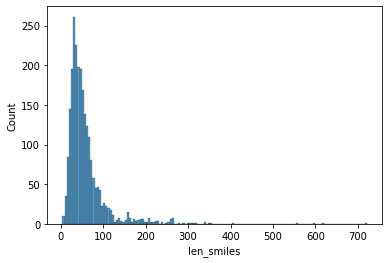

In [ ]:
sns.histplot(drug_rp_repurposing_2.len_smiles)

In [ ]:
# Restricting the length of the SMILES strings to 80 characters (due to computating power limits).
drug_rp_repurposing_2 = drug_rp_repurposing_2[drug_rp_repurposing_2['len_smiles'] <= 80]
drug_rp_repurposing_2.shape

(2034, 4)

In [ ]:
# Verifying longest SMILES string is 80 characters.
max_length = max(drug_rp_repurposing_2.len_smiles)

In [ ]:
drug_rp_repurposing_2['smiles_flat'] = drug_rp_repurposing_2.Smiles.apply(flat_smiles_encoder,  maxlen = 100)
print(drug_rp_repurposing_2.shape)
drug_rp_repurposing_2 = drug_rp_repurposing_2[drug_rp_repurposing_2['smiles_flat'].notna()]
print(drug_rp_repurposing_2.shape)

(2034, 5)
(2029, 5)


In [ ]:
display(drug_rp_repurposing_2)

,Name,Smiles,status,len_smiles,smiles_flat
0,(R)-(-)-apomorphine,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,False,38,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,abacavir,Nc1nc(NC2CC2)c2ncn([C@@H]3C[C@H](CO)C=C3)c2n1,False,45,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,abemaciclib,CCN1CCN(Cc2ccc(Nc3ncc(F)c(n3)-c3cc(F)c4nc(C)n(...,True,64,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,abiraterone,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@]34C...,True,67,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,abiraterone-acetate,CC(=O)O[C@H]1CC[C@]2(C)[C@H]3CC[C@@]4(C)[C@@H]...,True,75,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
2422,4-aminohippuric-acid,Nc1ccc(cc1)C(=O)NCC(O)=O,False,24,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2423,5-aminolevulinic-acid,NCC(=O)CCC(O)=O,False,15,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2424,5-fluorouracil,Fc1c[nH]c(=O)[nH]c1=O,True,21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2425,5-hydroxytryptophan,N[C@@H](Cc1c[nH]c2ccc(O)cc12)C(O)=O,False,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
len(drug_rp_repurposing_2.smiles_flat[0])

5600

In [ ]:
# Saving the information from the smiles_flat column to an array.
np.save('/content/drive/MyDrive/Data/smiles_drug_rp_full.npy', np.array(np.array(drug_rp_repurposing_2['smiles_flat'].to_list()), dtype = object), allow_pickle = True)

# Saving the information from the Name column to an array.
np.save('/content/drive/MyDrive/Data/id_drug_rp_full.npy', np.array(np.array(drug_rp_repurposing_2['Name'].to_list()), dtype = object), allow_pickle = True)

# Saving the information from the status column to an array.
np.save('/content/drive/MyDrive/Data/status_drug_rp_full.npy', np.array(np.array(drug_rp_repurposing_2['status'].to_list()), dtype = object), allow_pickle = True)

In [ ]:
drug_rp_repurposing_2_smiles = np.load('/content/drive/MyDrive/Data/smiles_drug_rp_full.npy', allow_pickle=True)
drug_rp_repurposing_2_id = np.load('/content/drive/MyDrive/Data/id_drug_rp_full.npy', allow_pickle=True)
drug_rp_repurposing_2_status = np.load('/content/drive/MyDrive/Data/status_drug_rp_full.npy', allow_pickle=True)

In [ ]:
drug_rp_repurposing_2_smiles

array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [ ]:
repurposed_drugs = pd.DataFrame(drug_rp_repurposing_2_id)
repurposed_drugs = repurposed_drugs.rename(columns = {0: 'Name'})
repurposed_drugs['Actual Status'] = drug_rp_repurposing_2_status
repurposed_drugs

,Name,Actual Status
0,(R)-(-)-apomorphine,False
1,abacavir,False
2,abemaciclib,True
3,abiraterone,True
4,abiraterone-acetate,True
...,...,...
2024,4-aminohippuric-acid,False
2025,5-aminolevulinic-acid,False
2026,5-fluorouracil,True
2027,5-hydroxytryptophan,False


In [ ]:
x_new = tf.convert_to_tensor(drug_rp_repurposing_2_smiles.astype(int))

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Results/Model_3/model_3.h5')

In [ ]:
y_pred_scores = model.predict(x_new)

64/64 [==============================] - 1s 3ms/step


In [ ]:
repurposed_drugs['Score'] = y_pred_scores
display(repurposed_drugs)

,Name,Actual Status,Score
0,(R)-(-)-apomorphine,False,2.414285e-05
1,abacavir,False,3.750939e-07
2,abemaciclib,True,1.221613e-03
3,abiraterone,True,1.002901e-02
4,abiraterone-acetate,True,1.182719e-08
...,...,...,...
2024,4-aminohippuric-acid,False,1.246507e-03
2025,5-aminolevulinic-acid,False,9.953285e-02
2026,5-fluorouracil,True,7.396071e-04
2027,5-hydroxytryptophan,False,9.244252e-01


<AxesSubplot:xlabel='Score', ylabel='Count'>

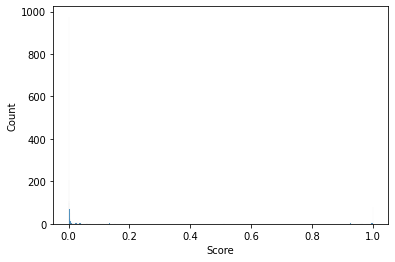

In [ ]:
sns.histplot(repurposed_drugs['Score'])

<AxesSubplot:xlabel='Score', ylabel='Count'>

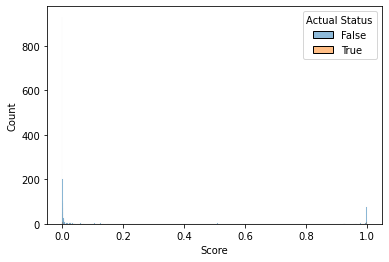

In [ ]:
sns.histplot(data = repurposed_drugs, x = 'Score', hue = 'Actual Status')

In [ ]:
threshold = 0.8

In [ ]:
repurposed_drugs['Predicted Status'] = repurposed_drugs.Score.apply(lambda x: True if x > threshold else False)

<AxesSubplot:xlabel='Actual Status', ylabel='Score'>

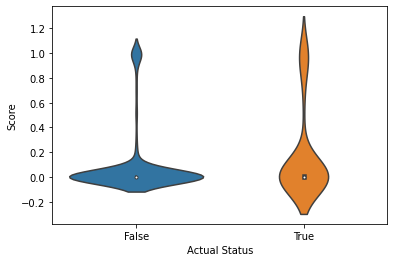

In [ ]:
sns.violinplot(data = repurposed_drugs, x = 'Actual Status', y = 'Score')

In [ ]:
# print(repurposed_drugs[repurposed_drugs.status == True]['score'].mean())
# print(repurposed_drugs[repurposed_drugs.status == False]['score'].mean())

In [ ]:
# Calculate true positive rate

# Calculate false negative rate


# See which ones are not currently cancer drugs, but are predicted to be cancer drugs --> short literature review on e.g. top 5 and see if they are in relevant pathways or in clinical trials etc

In [ ]:
def correctness(x, y):
  if x == True: # x represents the actual, labeled status of the drug.
    if y == True:
      return('True Positive')
    else:
      return('False Negative')
  else:
    if y == False:
      return('True Negative')
    else:
      return('False Positive')


### Final Dataset

In [ ]:
repurposed_drugs['Validity'] = repurposed_drugs.apply(lambda x: correctness(x['Actual Status'], x['Predicted Status']), axis = 1)
display(repurposed_drugs)

,Name,Actual Status,Score,Predicted Status,Validity
0,(R)-(-)-apomorphine,False,2.414285e-05,False,True Negative
1,abacavir,False,3.750939e-07,False,True Negative
2,abemaciclib,True,1.221613e-03,False,False Negative
3,abiraterone,True,1.002901e-02,False,False Negative
4,abiraterone-acetate,True,1.182719e-08,False,False Negative
...,...,...,...,...,...
2024,4-aminohippuric-acid,False,1.246507e-03,False,True Negative
2025,5-aminolevulinic-acid,False,9.953285e-02,False,True Negative
2026,5-fluorouracil,True,7.396071e-04,False,False Negative
2027,5-hydroxytryptophan,False,9.244252e-01,True,False Positive


In [ ]:
repurposed_drugs.to_csv('/content/drive/MyDrive/Results/repurposed_drugs.csv', index = True)

In [ ]:
print(len(repurposed_drugs[repurposed_drugs['Actual Status'] == 'True']))

0


In [ ]:
print(len(repurposed_drugs[repurposed_drugs['Validity'] == 'False Negative']))
print(len(repurposed_drugs[repurposed_drugs['Validity'] == 'False Positive']))
print(len(repurposed_drugs[repurposed_drugs['Validity'] == 'True Negative']))
print(len(repurposed_drugs[repurposed_drugs['Validity'] == 'True Positive']))

# Calculate accuracy

67
145
1805
12


In [ ]:
# false_negative = len(repurposed_drugs[repurposed_drugs['Validity'] == 'False Negative'])
# false_positive = len(repurposed_drugs[repurposed_drugs['Validity'] == 'False Positive'])
# true_negative = len(repurposed_drugs[repurposed_drugs['Validity'] == 'True Negative'])
# true_positive = len(repurposed_drugs[repurposed_drugs['Validity'] == 'True Positive'])

#### Scores

In [ ]:
FN = len(repurposed_drugs[repurposed_drugs['Validity'] == 'False Negative'])
FP = len(repurposed_drugs[repurposed_drugs['Validity'] == 'False Positive'])
TN = len(repurposed_drugs[repurposed_drugs['Validity'] == 'True Negative'])
TP = len(repurposed_drugs[repurposed_drugs['Validity'] == 'True Positive'])

In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(accuracy)

0.8955150320354854


In [ ]:
recall = TP / (TP + FN)
print(recall)

0.1518987341772152


In [ ]:
precision = TP / (TP + FP)
print(precision)

0.07643312101910828


In [ ]:
f1_score = 2 * ((precision * recall) / (precision + recall))
print(f1_score)

0.10169491525423728


In [ ]:
# import sklearn.metrics as metrics
# y_true = repurposed_drugs['Actual Status']
# y_scores = repurposed_drugs['Predicted Status']
# auc_roc = metrics.roc_auc_score(y_true, y_scores)

### Noncancer Drug Candidates

In [ ]:
noncancer_drugs = repurposed_drugs[repurposed_drugs.Score < threshold]

In [ ]:
display(noncancer_drugs)

,Name,Actual Status,Score,Predicted Status,Validity
0,(R)-(-)-apomorphine,False,2.414285e-05,False,True Negative
1,abacavir,False,3.750939e-07,False,True Negative
2,abemaciclib,True,1.221613e-03,False,False Negative
3,abiraterone,True,1.002901e-02,False,False Negative
4,abiraterone-acetate,True,1.182719e-08,False,False Negative
...,...,...,...,...,...
2022,3-(4-methylbenzylidene)camphor,False,6.331149e-02,False,True Negative
2024,4-aminohippuric-acid,False,1.246507e-03,False,True Negative
2025,5-aminolevulinic-acid,False,9.953285e-02,False,True Negative
2026,5-fluorouracil,True,7.396071e-04,False,False Negative


In [ ]:
noncancer_drugs.to_csv('/content/drive/MyDrive/Results/noncancer_drugs.csv', index = True)

### Potential Cancer Drugs

In [ ]:
potential_cancer_drugs = repurposed_drugs[repurposed_drugs.Validity == 'False Positive']

In [ ]:
display(potential_cancer_drugs)

,Name,Actual Status,Score,Predicted Status,Validity
19,acetohydroxamic-acid,False,1.000000,True,False Positive
24,acetylcysteine,False,0.996235,True,False Positive
25,acexamic-acid,False,0.980119,True,False Positive
79,altrenogest,False,1.000000,True,False Positive
82,alvimopan,False,1.000000,True,False Positive
...,...,...,...,...,...
1970,valpromide,False,0.964435,True,False Positive
1992,voriconazole,False,1.000000,True,False Positive
2005,zanamivir,False,0.999841,True,False Positive
2023,3-bromocamphor,False,0.996883,True,False Positive


In [ ]:
potential_cancer_drugs = potential_cancer_drugs.sort_values(by = 'Score', ascending = False)
display(potential_cancer_drugs)

,Name,Actual Status,Score,Predicted Status,Validity
561,dexrazoxane,False,1.000000,True,False Positive
1548,progesterone,False,1.000000,True,False Positive
1691,sevoflurane,False,1.000000,True,False Positive
389,chlormadinone-acetate,False,1.000000,True,False Positive
1634,rilmenidine,False,1.000000,True,False Positive
...,...,...,...,...,...
850,gemfibrozil,False,0.856558,True,False Positive
1572,protriptyline,False,0.854196,True,False Positive
1096,lynestrenol,False,0.845604,True,False Positive
541,dehydroepiandrosterone,False,0.833289,True,False Positive


In [ ]:
potential_cancer_drugs.to_csv('/content/drive/MyDrive/Results/potential_cancer_drugs.csv', index = True)

### Related Cancer Drugs

In [ ]:
confirmed = 1

In [ ]:
related_cancer_drugs = potential_cancer_drugs[potential_cancer_drugs.Score == confirmed]

In [ ]:
display(related_cancer_drugs)

,Name,Actual Status,Score,Predicted Status,Validity
561,dexrazoxane,False,1.0,True,False Positive
1548,progesterone,False,1.0,True,False Positive
1691,sevoflurane,False,1.0,True,False Positive
389,chlormadinone-acetate,False,1.0,True,False Positive
1634,rilmenidine,False,1.0,True,False Positive
1623,retinaldehyde,False,1.0,True,False Positive
718,ethambutol,False,1.0,True,False Positive
751,faropenem,False,1.0,True,False Positive
778,finasteride,False,1.0,True,False Positive
1531,prednisolone,False,1.0,True,False Positive


### Likely Cancer Candidates

In [ ]:
likely_candidates = potential_cancer_drugs.loc[potential_cancer_drugs['Name'] == 'ethosuximide'] # Select rows where ColumnA is 'XYZ'
likely_candidates = potential_cancer_drugs.iloc[0:] # Exclude everything before the first row where ColumnA is 'XYZ'

In [ ]:
likely_candidates.to_csv('/content/drive/MyDrive/Results/likely_candidates.csv', index = True)